![X-Ray - Image CC0 - pexels.com](https://raw.githubusercontent.com/alibell/mimic_cxr_clustering/main/img/pexels-anna-shvets-4226258.jpg?token=GHSAT0AAAAAABPS6I3BUX32NXNHCPF2757MYP6OSWQ)

Chest X-Ray encoder (CXRE)
==========================

## Description

We work in a randomly picked sample of 2% the [MIMIC-IV-CXR database](https://physionet.org/content/mimic-cxr/2.0.0/).
We based our worked on a derivated database name [MIMIC-CXR-JPG](https://physionet.org/content/mimic-cxr-jpg/2.0.0/) in order to work from a homogenized way to transform DICOM images to JPG and to perform features extraction from report notes.

We will work with JPG images instead of DICOM raw images mainly because of our harware limitation in disk storage.

## Getting data

In [4]:
import download_data

In [6]:
# Download the data
## Fill the token

token = ... # Fill the current line

#download_data.download_data(token=token, folder="./data")

## Data description

## Import and useful functions

In [7]:
import pandas as pd
import numpy as np
import glob
from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

In [8]:
class imageDataset(Dataset):
    def __init__ (self, images_paths):
        """
            Parameters:
            ----------
            images_paths : dict{int:str} containing image id and image path
        """
        super().__init__()

        self.image_paths = images_paths
        self.image_list = list(self.image_paths.keys()) # Useful for dataset splitting

    def split(self, p=0.3, random_seed=None):
        """
            Split the dataset

            Parameters:
            -----------
            p : pourcentage of split repartition
            random_seed

            Output:
            -------
            Tuple of image dataset object
        """

        if isinstance(p, float) == False or p > 1 or p < 0:
            raise ValueError("p should be between 0 and 1")

        if random_seed is not None and isinstance(random_seed, int):
            np.random.RandomState(random_seed)

            # Getting the splitted image list
            n_items = len(self.image_list)
            n_1 = int(n_items*p)
            n_2 = n_items-n_1

            mask = np.zeros(n_items).astype("bool")
            mask[np.random.choice(range(n_items), replace=False, size=n_1)] = True

            keys_1 = np.array(self.image_list)[mask]
            values_1 = np.array(list(self.image_paths.values()))[mask]
            dataset_1 = imageDataset(dict(zip(keys_1, values_1)))

            keys_2 = np.array(self.image_list)[mask == False]
            values_2 = np.array(list(self.image_paths.values()))[mask == False]
            dataset_2 = imageDataset(dict(zip(keys_2, values_2)))

        return dataset_1, dataset_2

    def __str__(self):
        n_data = self.__len__()

        return(f"CXR Dataset of {n_data} images")

    def __repr__(self):
        return self.__str__()

    def __len__(self):
        return len(self.image_paths.keys())

    def __get_image (self, image_path):
        image = np.array(
                    Image.open(image_path)
        )

        return image

    def __getitem__(self, s):
        images = []

        # Getting indices range
        if isinstance(s, slice):
            start = s.start if s.start is not None else 0
            stop = s.stop if s.stop is not None else self.__len__()
            step = s.step if s.step is not None else 1
    
            indices = range(start, stop, step)
        elif isinstance(s, int):
            indices = [s]
        else:
            raise NotImplementedError
        
        for idx in indices:
            images.append(
                self.__get_image(self.image_paths[self.image_list[idx]])
            )
        
        return images

    def get_from_id(self,  id):
        
        return self.__get_image(self.image_paths[id])

In [9]:
def get_data(data_folder="./data"):
    """
        Parameters
        ----------
        data_folder: str, folder containing the date

        Return
        ------
        - tuple containing :
            > an image dataset object
            > a pandas dataframe of metadata
        - dataframe of labels
    """

    # Creating an UID
    df_expert = pd.read_csv(f"{data_folder}/mimic-cxr-2.0.0-chexpert.csv.gz")
    df_metadata = pd.read_csv(f"{data_folder}/mimic-cxr-2.0.0-metadata.csv.gz")

    df_metadata = df_metadata.reset_index() \
        .rename(columns = {"index":"uid"}) \
        .drop(columns = ["Unnamed: 0"])

    df_expert = df_expert \
        .drop(columns = ["Unnamed: 0"]) \
        .join(df_metadata[["study_id","uid"]].set_index("study_id"), on = "study_id") \
        .set_index("uid") \
        .sort_index() \
        .reset_index(drop=False)
        
    df_expert["text_label"] = df_expert.iloc[:,3:].apply(
        lambda x: ",".join(x.dropna()[x.dropna() == 1].index.tolist())
    , axis=1)

    # Getting image loader

    ## Getting image path dict
    images_paths = df_metadata[["uid", "subject_id", "dicom_id", "study_id"]] \
                    .reset_index(drop=True)

    images_paths["subject_id_str"] = images_paths["subject_id"].astype("str")
    images_paths["study_id_str"] = images_paths["study_id"].astype("str")

    images_paths["path"] = f"{data_folder}/./files/p"+images_paths["subject_id_str"].str.slice(0,2)+"/p"+ \
        +images_paths["subject_id_str"]+"/s"+ \
        +images_paths["study_id_str"]+"/"+ \
        +images_paths["dicom_id"]+".jpg"

    images_paths = images_paths[["uid","path"]].set_index("uid")["path"] \
            .to_dict()

    ## Loading images
    images_dataset = imageDataset(images_paths)

    return (images_dataset, df_metadata), df_expert

Image are stored as JPG file in the data/files folder.
We created a simple dataloader for image loading.

In [10]:
# This function get the image dataloader and the metadata

# Getting the data
X, y = get_data()

## Images data and metadata

### Images

X is a tuple, it contains :
- The image dataloader
- The image metadata

In [11]:
X[0]

CXR Dataset of 7504 images

Each image has an unique id, the images id / path correspondance is stored in the image_paths dictionnary :

In [12]:
j = 0
for i in X[0].image_paths.items():
    print(i)
    j += 1

    if j > 5:
        break

(0, './data/./files/p10/p10001401/s58747570/19e55bee-714bb193-0968d683-5bf655a5-7b5caba9.jpg')
(1, './data/./files/p10/p10001401/s58747570/f56a3d51-284b2466-262661f1-2567a6ab-248f4ae3.jpg')
(2, './data/./files/p10/p10002930/s55885481/84c6ecc4-fd81e31d-1e879d18-13024211-35de54ad.jpg')
(3, './data/./files/p10/p10002930/s55885481/eb71d6af-79edf48e-4fecee5b-133fa0e2-614d733f.jpg')
(4, './data/./files/p10/p10003019/s52117631/291d51fa-d786f2a5-7519f2fa-409c3d4a-6465003c.jpg')
(5, './data/./files/p10/p10003019/s52117631/4439f6fd-4a3c54c3-daa16c0c-d1513500-83002db5.jpg')


You can call an image from its relative location in the image loader, be careful this location does not necessary correspond to the image id :

In [13]:
X[0][1]

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]

The image is stored as a numpy array, and can be displayed with imshow :

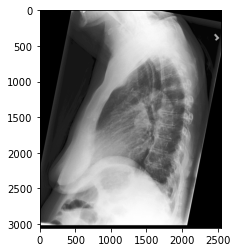

In [14]:
plt.imshow(X[0][1][0], cmap="gray")

You can get multiples image at once by slicing the image loader :

In [15]:
len(X[0][5:10])

5

You can get the image by calling the get_from_id function :

In [16]:
X[0].get_from_id(5)

array([[254, 255, 253, ...,  60,  71,  97],
       [255, 255, 253, ...,  67,  62,  75],
       [250, 255, 255, ...,  75,  76,  76],
       ...,
       [255, 255, 255, ..., 240, 253, 255],
       [255, 255, 255, ..., 255, 254, 255],
       [255, 255, 255, ..., 252, 254, 255]], dtype=uint8)

### Metadata

Each image is associated with metadata which could be used for image encoding.
The uid correspond to the image unique id.

In [17]:
X[1].head(2)

,uid,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,0,19e55bee-714bb193-0968d683-5bf655a5-7b5caba9,10001401,58747570,CHEST (PA AND LAT),PA,3056,2544,21310730,134837.843,CHEST (PA AND LAT),postero-anterior,Erect
1,1,f56a3d51-284b2466-262661f1-2567a6ab-248f4ae3,10001401,58747570,CHEST (PA AND LAT),LATERAL,3056,2544,21310730,134837.843,CHEST (PA AND LAT),lateral,Erect


These metadata contains information about the image acquisition.

<AxesSubplot:>

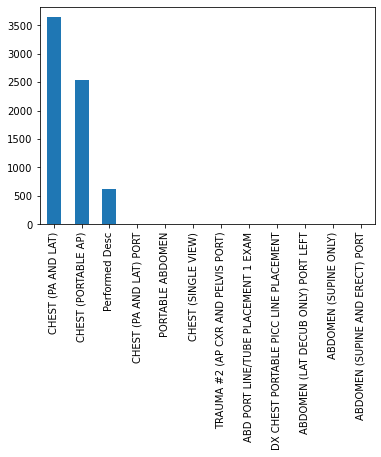

In [18]:
X[1]["PerformedProcedureStepDescription"].value_counts().plot.bar()

<AxesSubplot:>

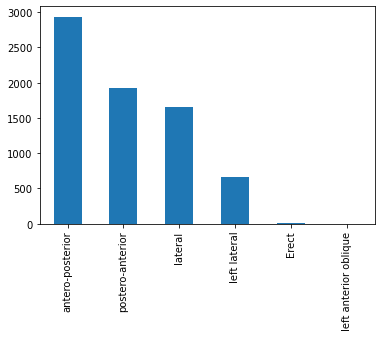

In [19]:
X[1]["ViewCodeSequence_CodeMeaning"].value_counts().plot.bar()

## Labels

The y dataframe contain the labels.

In [20]:
y.head(5)

,uid,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,text_label
0,0,10001401,58747570,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,No Finding
1,1,10001401,58747570,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,No Finding
2,2,10002930,55885481,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Atelectasis,Fracture"
3,3,10002930,55885481,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Atelectasis,Fracture"
4,4,10003019,52117631,1.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,0.0,NaN,NaN,"Atelectasis,Lung Lesion,Lung Opacity,Pleural O..."


We added a text_label for easily plot the global label of an image.
It could be useful to identify the clusters.

Let's plot the labels.

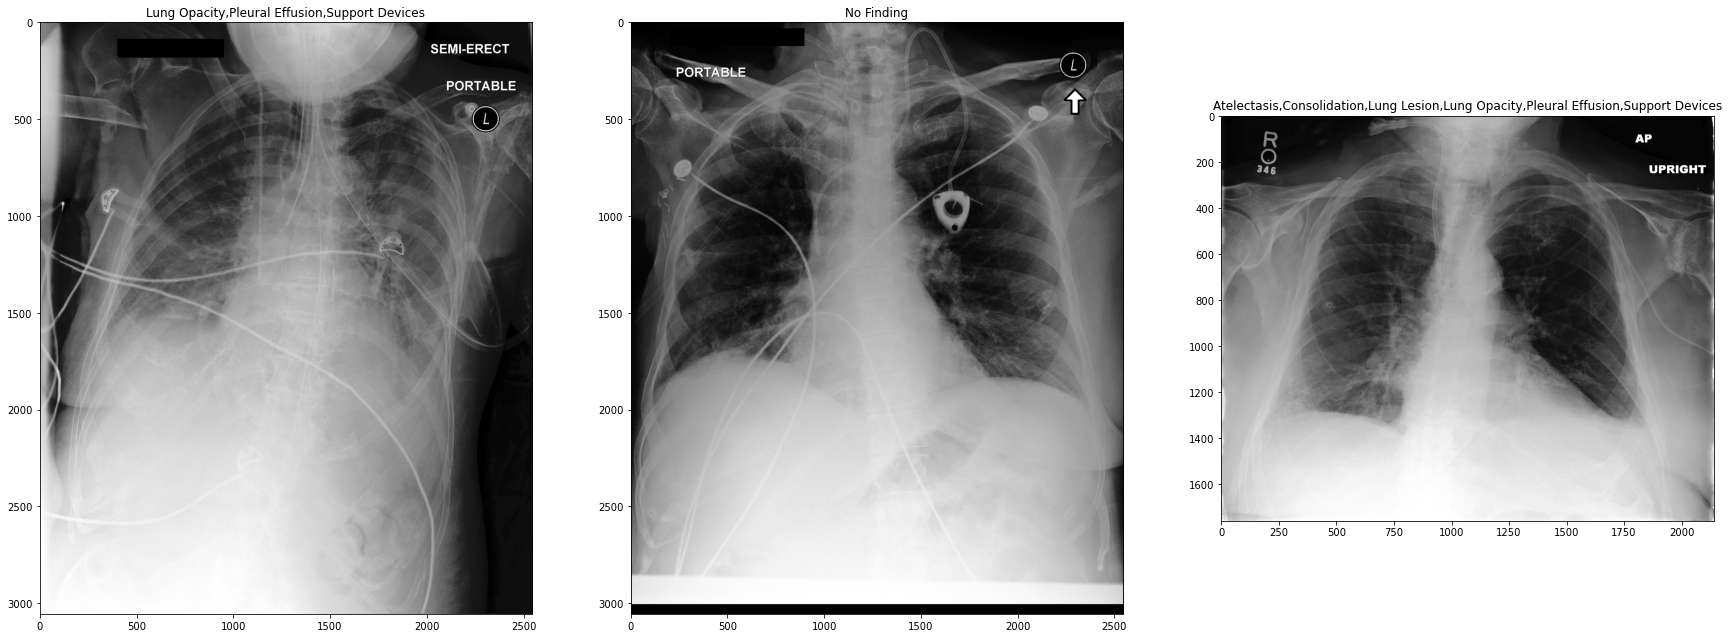

In [39]:
figs, axs = plt.subplots(1,3, figsize=(30,20))
axs = axs.flatten()

start_id = 210
end_id = start_id+3

images = X[0][start_id:end_id]
for (i, j) in zip(range(len(images)), range(start_id, end_id, 1)):
    axs[i].imshow(
        images[i],
        cmap="gray"
    )
    axs[i].set_title(y.loc[j,"text_label"])

# Train - Test split

The image dataloader is given with a split function.
It is important to use it as the dataloader cannot be splitted with usual function such a sklearn train_test_split.

In [472]:
# Splitting train and test
X0_train, X0_test = X[0].split(p=0.7, random_seed=42)

We call also split metadata and the y according to the dataloader splits.
For that, we could use the `image_list` attribute which contains the list of the images uids.

In [477]:
train_id = X0_train.image_list
test_id = X0_test.image_list

Then, we take the image by uid

In [482]:
X1_train = X[1].set_index("uid").loc[train_id,:].reset_index()
X1_test = X[1].set_index("uid").loc[test_id,:].reset_index()

y_train = y.set_index("uid").loc[train_id,:].reset_index(drop=True)
y_test = y.set_index("uid").loc[test_id,:].reset_index(drop=True)

In [486]:
print(X0_train)
print(X0_test)

CXR Dataset of 5252 images
CXR Dataset of 2252 images


In [487]:
print(X1_train.shape)
print(X1_test.shape)

(5252, 13)
(2252, 13)


In [488]:
print(y_train.shape)
print(y_test.shape)

(5252, 17)
(2252, 17)
